# Ordered MNIST digits examample from Kostic et al. NeurIPS 2022

## Data pipeline

In [1]:
#Configs
import ml_confs as mlcfg
configs = mlcfg.from_file('configs.yaml', register_jax_pytree=False)

In [2]:
#Data pipeline
from datasets import load_from_disk
ordered_MNIST = load_from_disk('__data__')

#Creating a copy of the dataset in numpy format
np_ordered_MNIST = ordered_MNIST.with_format(type='numpy', columns=['image', 'label'])

train (800) example: tensor([0, 1, 2, 3, 4])
test (1001) example: tensor([0, 1, 2, 3, 4])
validation (201) example: tensor([0, 1, 2, 3, 4])


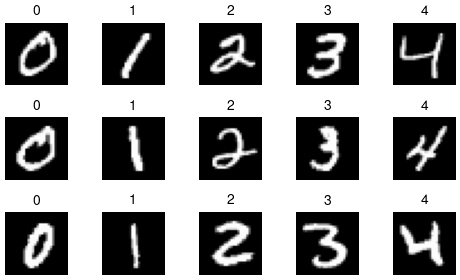

In [22]:
#Checking the data
import matplotlib.pyplot as plt
#Set plotting styles
import scienceplots
plt.style.use(['nature', 'retro'])
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9

fig, ax = plt.subplots(3, configs.classes, figsize=(configs.classes, 3))
for j, split in enumerate(['train', 'test', 'validation']):
    print(f'{split} ({len(ordered_MNIST[split])}) example: {ordered_MNIST[split]["label"][:configs.classes]}')
    for i in range(configs.classes):
        data = ordered_MNIST['train'][configs.classes*j + i]
        ax[j, i].imshow(data['image'], cmap='gray')
        ax[j, i].set_title(data['label'].item())
        ax[j, i].axis('off')
fig.tight_layout()

## Setting up a validation scheme
The validation of each model will be performed as follows: starting from a test image of the digit $c$, we will predict the next image by calling `model.predict`. The prediction should be an MNIST-alike image of the digit $c+1$ (modulo `configs.classes`). We will feed this prediction to a very strong MNIST classifier, and evaluate how its accuracy degrades over time.

### Defining the _oracle_ classifier

In [20]:
import torch.nn as nn
import torch

#Setting up the architecture
class CNNEncoder(nn.Module):
    def __init__(self, num_classes):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output num_classes classes
        self.out = nn.Sequential(
            nn.Linear(32 * 7 * 7, num_classes)
        )  
        torch.nn.init.orthogonal_(self.out[0].weight)      
    
    def forward(self, X):
        if X.dim() == 3:
            X = X.unsqueeze(1) # Add a channel dimension if needed
        X = self.conv1(X)
        X = self.conv2(X)
        # Flatten the output of conv2
        X = X.view(X.size(0), -1)       
        output = self.out(X)
        return output

We wrap the oracle classifier around a `kooplearn.abc.TrainableFeatureMap`. This will allow us to easily replicate the setting of Kostic et al. 2022, and it is pedagogical to show how `kooplearn` can be extended.

In [11]:
from kooplearn.abc import TrainableFeatureMap

import os
from pathlib import Path
from typing import Optional
import logging
import pickle

import lightning
import numpy as np

#Following kooplearn implementations, we define a Pytorch Lightning module and then wrap it in a TrainableFeatureMap
class ClassifierModule(lightning.LightningModule):
    def __init__(self, num_classes: int, learning_rate: float):
        super().__init__()
        self.num_classes = num_classes
        self.encoder = CNNEncoder(num_classes=num_classes)
        self.learning_rate = learning_rate
        self.loss_fn = torch.nn.CrossEntropyLoss()

        # Set up storage for metrics
        self.train_acc = []
        self.train_steps = []
        self.val_acc = []
        self.val_steps = []
    
    def on_fit_start(self):
        self.train_acc = []
        self.train_steps = []
        self.val_acc = []
        self.val_steps = []

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = self.learning_rate)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        images, labels = batch['image'], batch['label']
        output = self.encoder(images)               
        loss = self.loss_fn(output, labels)
        with torch.no_grad():
            pred_labels = output.argmax(dim=1)
            accuracy = (pred_labels == labels).float().mean()
        
        #Log metrics
        self.train_acc.append(accuracy.item())
        self.train_steps.append(self.global_step)
        
        return {'loss': loss, 'train/accuracy': accuracy}
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch['image'], batch['label']
        output = self.encoder(images)  
        pred_labels = output.argmax(dim=1)
        accuracy = (pred_labels == labels).float().mean() # Scalar

        self.val_acc.append(accuracy.item())
        self.val_steps.append(self.global_step)

        return {'val/accuracy': accuracy}
    
class ClassifierFeatureMap(TrainableFeatureMap):
    def __init__(
                self, 
                num_classes: int,
                learning_rate: float,
                trainer: lightning.Trainer,
                seed: Optional[int] = None  
                ):
        #Set rng seed
        lightning.seed_everything(seed)
        self.seed = seed
        self.lightning_module = ClassifierModule(num_classes, learning_rate)
        
        #Init trainer
        self.lightning_trainer = trainer
        self._is_fitted = False
        
    @property
    def is_fitted(self) -> bool:
        return self._is_fitted
    
    @property
    def lookback_len(self) -> int:
        return 1 #Hardcoding it here, as we are not using lookback windows
    
    #Not tested
    def save(self, path: os.PathLike):
        path = Path(path)
        path.mkdir(parents=True, exist_ok=True)
        #Save the trainer
        torch.save(self.lightning_trainer, path / 'lightning_trainer.bin')
        #Save the lightning checkpoint
        ckpt = path / 'lightning.ckpt'
        self.lightning_trainer.save_checkpoint(str(ckpt))
        del self.lightning_module
        del self.lightning_trainer
        model = path / 'kooplearn_model.pkl'
        with open (model, 'wb') as f:
            pickle.dump(self, f)  
    
    #Not tested
    @classmethod
    def load(cls, path: os.PathLike):
        path = Path(path)
        trainer = torch.load(path / 'lightning_trainer.bin')
        ckpt = path / 'lightning.ckpt'
        with open(path / 'kooplearn_model.pkl', 'rb') as f:
            restored_obj = pickle.load(f)
        assert isinstance(restored_obj, cls)
        restored_obj.lightning_trainer = trainer
        restored_obj.lightning_module = ClassifierModule.load_from_checkpoint(str(ckpt))
        return restored_obj

    def fit(self, **trainer_fit_kwargs: dict):
        if 'model' in trainer_fit_kwargs:
            logging.warn("The 'model' keyword should not be specified in trainer_fit_kwargs. The model is automatically set to the DPNet feature map, and the provided model is ignored.")
            trainer_fit_kwargs = trainer_fit_kwargs.copy()
            del trainer_fit_kwargs['model']
        self.lightning_trainer.fit(model=self.lightning_module, **trainer_fit_kwargs)
        self._is_fitted = True

    def __call__(self, X: np.ndarray) -> np.ndarray:
        X = torch.from_numpy(X).float()
        X.to(self.lightning_module.device)
        self.lightning_module.eval()
        with torch.no_grad():
            embedded_X = self.lightning_module.encoder(X)
            embedded_X = embedded_X.detach().cpu().numpy()
        return embedded_X

Let's train `ClassifierFeatureMap` on our `ordered_MNIST` dataset

In [13]:
from torch.utils.data import DataLoader
train_dl = DataLoader(ordered_MNIST['train'], batch_size=configs.batch_size, shuffle=True)
val_dl = DataLoader(ordered_MNIST['validation'], batch_size=len(ordered_MNIST['validation']), shuffle=False)
        
trainer_kwargs = {
    'accelerator': 'gpu',
    'max_epochs': 20,
    'log_every_n_steps': 2,
    'enable_progress_bar': False,
    'devices': 1
}

trainer = lightning.Trainer(**trainer_kwargs)

oracle = ClassifierFeatureMap(
    configs.classes,
    1e-2,
    trainer, 
    seed=configs.rng_seed
)

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*") #Ignore warnings about num_workers

oracle.fit(train_dataloaders=train_dl, val_dataloaders=val_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type             | Params
---------------------------------------------
0 | encoder | CNNEncoder       | 21.1 K
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
21.1 K    Trainable params
0         Non-trainable params
21.1 K    Total params
0.084     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=20` reached.


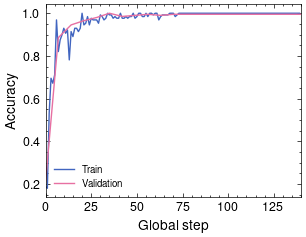

In [23]:
fig, ax = plt.subplots(1, 1)
ax.plot(oracle.lightning_module.train_steps, oracle.lightning_module.train_acc, label='Train')
ax.plot(oracle.lightning_module.val_steps, oracle.lightning_module.val_acc, label='Validation')
ax.set_xlabel('Global step')
ax.set_ylabel('Accuracy')
ax.legend(frameon=False)
ax.margins(x=0)

In [24]:
from kooplearn.abc import BaseModel
def evaluate_model(model: BaseModel, test_data):
    assert model.is_fitted
    test_labels = test_data['label']
    test_images = test_data['image']
    test_images = np.expand_dims(test_images, 1)
    report = {
        'accuracy': [],
        'label': [],
        'image': [],
        'times': []
    }
    for t in range(1, configs.eval_up_to_t + 1):
        pred = model.predict(test_images, t=t).reshape(-1, 28 ,28)
        pred_labels = oracle(pred)
        pred_labels = pred_labels.argmax(axis=1)
        accuracy = (pred_labels == (test_labels + t)%configs.classes ).mean()
        report['accuracy'].append(accuracy)
        report['image'].append(pred)
        report['label'].append(pred_labels)
        report['times'].append(t)
    return report

## Fitting some models with `kooplearn`

In [26]:
from kooplearn.models import DMD, KernelDMD, DeepEDMD
from kooplearn.data import traj_to_contexts

train_data = traj_to_contexts(np_ordered_MNIST['train']['image'])
val_data = traj_to_contexts(np_ordered_MNIST['validation']['image'])
transfer_operator_models = {}

#### Dynamic Mode Decomposition (DMD)

In [28]:
dmd_model = DMD(reduced_rank = configs.reduced_rank, rank=configs.classes).fit(train_data)
print(f"Train risk: {dmd_model.risk():.3f}\nValidation risk: {dmd_model.risk(val_data):.3f}")
transfer_operator_models['DMD'] = dmd_model

Fitted DMD model. Lookback length set to 1
Train risk: 51.510
Validation risk: 49.081


#### Classifier features (as in Sec. 6 of Kostic et al. 2022)

In [29]:
classifier_model = DeepEDMD(oracle, reduced_rank=False, rank=configs.classes).fit(train_data.copy())
print(f"Train risk: {classifier_model.risk():.3f}\nValidation risk: {classifier_model.risk(val_data.copy()):.3f}")
transfer_operator_models['Classifier-DeepEDMD'] = classifier_model

Fitted DeepEDMD model. Lookback length set to 1
Train risk: 174.220
Validation risk: 179.192


### Gaussian KernelDMD

In [30]:
#Optimization of the kernel lengthscale:
from sklearn.gaussian_process.kernels import RBF
from tqdm.notebook import tqdm
#The median heuristic is a good starting point
from scipy.spatial.distance import pdist
pairwise_distances = pdist(np_ordered_MNIST['train']['image'].reshape(np_ordered_MNIST['train']['image'].shape[0], -1))
ls0 = np.median(pairwise_distances)
#Average deviation from the median
d_ls = np.sqrt(np.mean((pairwise_distances - ls0)**2))
num_std = 5
length_scales = np.linspace(ls0 - num_std*d_ls, ls0 + num_std*d_ls, 11) #Search in a interval around the median heuristic
val_accuracies = []
for ls in tqdm(length_scales, desc='Lengthscale search'):
    _kernel_model = KernelDMD(kernel=RBF(ls), reduced_rank = configs.reduced_rank, rank=configs.classes).fit(train_data)
    acc = evaluate_model(_kernel_model, np_ordered_MNIST['validation'])['accuracy']
    val_accuracies.append(acc)
val_accuracies = np.array(val_accuracies)
best_ls = length_scales[np.argmax(val_accuracies.mean(axis=1))]
print(f"Median heuristic: {ls0:.3f}")
print(f"Best lengthscale: {best_ls:.3f} - Score {np.max(val_accuracies.mean(axis=1))}")

Lengthscale search:   0%|          | 0/11 [00:00<?, ?it/s]

Fitted KernelDMD model. Lookback length set to 1
Fitted KernelDMD model. Lookback length set to 1
Fitted KernelDMD model. Lookback length set to 1
Fitted KernelDMD model. Lookback length set to 1
Fitted KernelDMD model. Lookback length set to 1
Fitted KernelDMD model. Lookback length set to 1
Fitted KernelDMD model. Lookback length set to 1
Fitted KernelDMD model. Lookback length set to 1
Fitted KernelDMD model. Lookback length set to 1
Fitted KernelDMD model. Lookback length set to 1
Fitted KernelDMD model. Lookback length set to 1
Median heuristic: 10.484
Best lengthscale: 4.047 - Score 0.2902155887230514


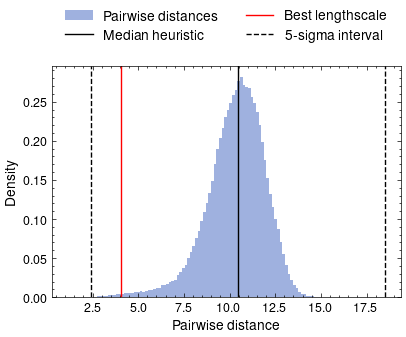

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 3))
ax.hist(pairwise_distances, bins=100, density=True, label='Pairwise distances', alpha = 0.5)
ax.axvline(ls0, color='k', label='Median heuristic')
ax.axvline(best_ls, color='r', label='Best lengthscale')
ax.axvline(ls0 + num_std*d_ls, color='k', linestyle='--', label=f'{num_std}-sigma interval')
ax.axvline(ls0 - num_std*d_ls, color='k', linestyle='--')
ax.set_xlabel('Pairwise distance')
ax.set_ylabel('Density')
ax.legend(loc='lower left', bbox_to_anchor=(0, 1.05, 1, 1.05), ncol=2, fontsize=10, frameon=False)

In [34]:
kernel_model = KernelDMD(kernel=RBF(best_ls), reduced_rank = configs.reduced_rank, rank=configs.classes, svd_solver='arnoldi').fit(train_data)
print(f"Train risk: {kernel_model.risk():.3f}\nValidation risk: {kernel_model.risk(val_data):.3f}")
transfer_operator_models['RBF-KernelDMD'] = kernel_model

Fitted KernelDMD model. Lookback length set to 1
Train risk: 0.906
Validation risk: 0.913


### Preparing `Dataloader`s for deep-learning feature maps

In [35]:
from kooplearn.nn.data import TrajToContextsDataset

train_ds = TrajToContextsDataset(ordered_MNIST['train']['image'])
val_ds = TrajToContextsDataset(ordered_MNIST['validation']['image'])

train_dl = DataLoader(train_ds, batch_size=configs.batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=len(val_ds), shuffle=False)

### VAMPNets

In [36]:
from kooplearn.models.feature_maps import VAMPNet

trainer_kwargs = {
    'accelerator': 'gpu',
    'devices': 1,
    'max_epochs': configs.max_epochs,  
    'log_every_n_steps': 3,
}
trainer = lightning.Trainer(**trainer_kwargs)

#Defining the model
feature_map = VAMPNet(
    CNNEncoder,
    torch.optim.Adam,
    {'lr': 1e-4},
    trainer,
    {'num_classes': configs.classes},
    center_covariances=False
)
feature_map.fit(train_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name | Type       | Params
------------------------------------
0 | lobe | CNNEncoder | 21.1 K
------------------------------------
21.1 K    Trainable params
0         Non-trainable params
21.1 K    Total params
0.084     Total estimated model params size (MB)


Fitting VAMPNet. Lookback window length set to 1


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [38]:
VAMPNet_model = DeepEDMD(feature_map, reduced_rank = configs.reduced_rank, rank=configs.classes).fit(train_data)
print(f"Train risk: {kernel_model.risk():.3f}\nValidation risk: {kernel_model.risk(val_data):.3f}")
transfer_operator_models['VAMPNet-2'] = VAMPNet_model

Fitted DeepEDMD model. Lookback length set to 1
Train risk: 0.906
Validation risk: 0.913


### DPNets

## Examining the results

In [39]:
report = {}
for model_name, model in transfer_operator_models.items():
    print(f"Evaluating {model_name}")
    report[model_name] = evaluate_model(model, np_ordered_MNIST['test'])

Evaluating DMD
Evaluating Classifier-DeepEDMD
Evaluating RBF-KernelDMD
Evaluating VAMPNet-2


Text(0.5, 1.0, 'Classifier accuracy')

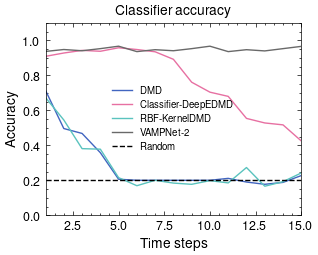

In [40]:
fig, ax = plt.subplots()
for model_name in report.keys():
    t = report[model_name]['times']
    acc = report[model_name]['accuracy']
    ax.plot(t, acc, label=model_name)

ax.axhline(1/configs.classes, color='black', linestyle='--', label='Random')

ax.legend(frameon=False)
ax.margins(x=0)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Time steps')
ax.set_ylabel('Accuracy')
ax.set_title('Classifier accuracy')

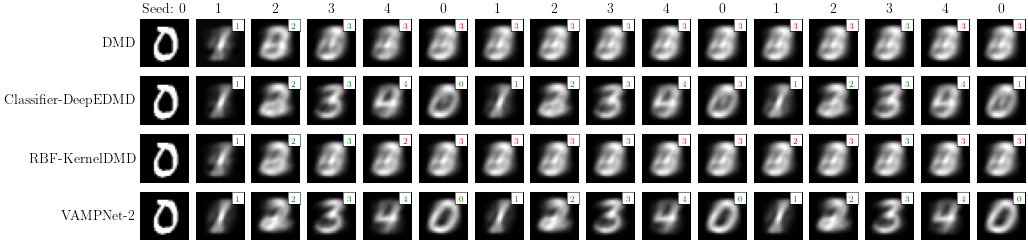

In [26]:
n_models = len(report.keys())
num_cols = configs.eval_up_to_t + 1
fig, axes = plt.subplots(n_models, num_cols, figsize=(num_cols, n_models), sharex=True, sharey=True)

test_seed_idx = 20
# Remove margins between columns
plt.subplots_adjust(wspace=0)

for model_idx, model_name in enumerate(report.keys()):
    ax = axes[model_idx, 0]
    ax.imshow(np_ordered_MNIST['test']['image'][test_seed_idx], cmap='gray')
    # Remove axes and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    model_eval = report[model_name]

    for t_idx in range(num_cols - 1):
        pred_label = model_eval['label'][t_idx][test_seed_idx]
        true_label = (np_ordered_MNIST['test']['label'][test_seed_idx] + model_eval['times'][t_idx])%configs.classes
        img = model_eval['image'][t_idx][test_seed_idx]
        
        # Set subplot for the current class
        ax = axes[model_idx, t_idx + 1]
        
        # Plot the MNIST image
        ax.imshow(img, cmap='gray')
        
        # Remove axes and ticks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')

        # Add a white background for the subplot
        ax.set_facecolor('white')
        
        # Add an inset for the predicted label in the upper right corner
        if pred_label == true_label:
            color = 'green'
        else:
            color = 'red'
        inset_ax = ax.inset_axes([0.75, 0.75, 0.25, 0.25])
        inset_ax.set_xlim(0, 1)
        inset_ax.set_ylim(0, 1)
        inset_ax.text(0.5, 0.4, f"{pred_label}" , color=color, fontsize=9, ha='center', va='center')
        inset_ax.set_xticks([])
        inset_ax.set_yticks([])
        #inset_ax.axis('off')
        inset_ax.set_facecolor('white')
        

# Display the model names on the left of each row
for model_idx, model_name in enumerate(report.keys()):
    axes[model_idx, 0].text(-0.1, 0.5, model_name, fontsize=14, ha='right', va='center', transform=axes[model_idx, 0].transAxes)

for class_idx in range(num_cols):
    title = (np_ordered_MNIST['test']['label'][test_seed_idx] + class_idx)%configs.classes
    if class_idx == 0:
        axes[0, class_idx].set_title(f"Seed: {title}", fontsize=14)
    else:
        axes[0, class_idx].set_title(f"{title}", fontsize=14)

plt.show()